In [1]:
# import packages 
import numpy as np 

import h5py
import os
import re

from scipy import stats
from scipy import signal
import scipy.optimize

import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib as mpl
import matplotlib.cm as mpl_cm
import matplotlib.colors as mpl_colors
import matplotlib.offsetbox as mpl_offsetbox
import matplotlib.gridspec as mpl_gridspec

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# change font
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "Arial"
# mpl.rcParams.update({'font.size': 6.5})
mpl.rcParams.update({'font.size': 8})

print(mpl.rcParams['font.family'])
print(mpl.rcParams['font.sans-serif'])
print(mpl.rcParams['font.size'])

['Arial']
['Arial']
8.0


In [2]:
# Save progress 
HISTORY_FILEPATH = r"\\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\TrialRasterPlotVer03.py"
LAST_SAVE_TIME = 0
SAVE_INTERVAL_S = 5*60
def SAVE_PROGRESS(dst_file_path):
    global LAST_SAVE_TIME, SAVE_INTERVAL_S
    import time
    cur_time = time.time()
    if (cur_time - LAST_SAVE_TIME) < SAVE_INTERVAL_S:
        print(f"Time since last sync = {(cur_time - LAST_SAVE_TIME):0.2f} s" )
        return
    LAST_SAVE_TIME = cur_time
    try:
        from datetime import datetime
        dst_dir_path, dst_file_name = os.path.split(dst_file_path)
        dst_file_name = os.path.splitext(dst_file_name)[0] + "_" + datetime.today().strftime('%Y-%m-%d') + os.path.splitext(dst_file_name)[1]
        dst_file_path = os.path.join(dst_dir_path, dst_file_name)
        if not os.path.isdir(dst_dir_path):
            os.makedirs(dst_dir_path)
        if os.path.exists(dst_file_path):
            os.remove(dst_file_path)
        %history -t -g -f $dst_file_path
        dst_notebook_path = os.path.splitext(dst_file_path)[0] + ".ipynb"
        %notebook $dst_notebook_path
        print("Progress saved to: " + dst_file_path)
    except Exception as e:
        print("Progress sync failed, error: ",e)

In [3]:
# count spike in time stamp
def cnt_spike_in_time_stamp(spike_event, stim_tstamp):
    
    nof_traces = spike_event.shape[0]
    trace_len = spike_event.shape[1]
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    spike_cnts = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
        
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_start = max(0, tstamp_start)
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            tstamp_end = min(trace_len, tstamp_end)
            if tstamp_start >= tstamp_end:
                continue
            tstamp_spike_event_mask = spike_event[:, tstamp_start:tstamp_end] > 0
            nof_spikes = np.sum(tstamp_spike_event_mask.astype(int), axis = -1)
            spike_cnts[i_orint, i_step, :] = nof_spikes
            
    return spike_cnts

def calculate_spike_rate_s(spike_cnts, stim_tstamp_s):
    nof_orint = spike_cnts.shape[0]
    nof_steps = spike_cnts.shape[1]
    nof_traces = spike_cnts.shape[2]
    
    spike_rate = np.zeros((nof_orint, nof_steps, nof_traces), dtype = np.float)
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            stamp_t_s = stim_tstamp_s[i_orint, i_step, :]
            duration_s = stamp_t_s[-1] - stamp_t_s[0]
            if duration_s == 0:
                continue
            spike_rate[i_orint, i_step, :] = spike_cnts[i_orint, i_step, :].astype(np.float) / duration_s
            
    return spike_rate

def bw_lp_filtering(order, cutoff, fs, src_traces):
    b, a = signal.butter(order, cutoff, "lp", fs = fs, output = "ba")
    dst_traces = signal.filtfilt(b, a, src_traces, method="gust", axis = -1)
    return dst_traces
    
SAVE_PROGRESS(HISTORY_FILEPATH)  

Progress saved to: \\10.254.8.27\JILAB3-Quota\Jian\Backup\JupyterNotebookBackup\TrialRasterPlotVer03_2024-03-25.py


In [4]:
# basic plot functions
def raster_plot(spike_events, event_color = "k"):
    plt_xs = np.arange(spike_events.shape[1])
    event_xs = []
    for i_trail in range(spike_events.shape[0]):
        event_xs.append(plt_xs[spike_events[i_trail,:] > 0])
    plt.eventplot(event_xs, color = event_color,
                 lineoffsets = 1,
                 linelengths = 1,
                 linewidths = 0.5)

def stim_time_stamp_axvspan(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvspan(tstamp_start, tstamp_end, facecolor = facecolor_strs[i_step], alpha=0.1)

def stim_time_stamp_axvline(stim_tstamp, facecolor_strs = ['b', 'r', 'b']):
    nof_orint = stim_tstamp.shape[0]
    nof_steps = stim_tstamp.shape[1]
    
    for i_orint in range(nof_orint):
        for i_step in range(nof_steps):
            tstamp_start = stim_tstamp[i_orint, i_step, 0]
            tstamp_end = stim_tstamp[i_orint, i_step, 1]
            if tstamp_start >= tstamp_end:
                continue
            plt.axvline(tstamp_start, color = facecolor_strs[i_step])
            plt.axvline(tstamp_end, color = facecolor_strs[i_step])
    
SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 22.75 s


In [5]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl_colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 22.76 s


In [6]:
# create customized colormap

truncate_pink = truncate_colormap(plt.get_cmap("pink"), 0.2, 1)
truncate_pink_r = truncate_colormap(plt.get_cmap("pink_r"), 0, 0.8)
truncate_gray = truncate_colormap(plt.get_cmap("gray"), 0.2, 1)

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 22.78 s


In [7]:
# display configuration

my_monitor_dpi_px = 96
illustrator_mointor_dpi_px = 72
letter_paper_size_inch = np.array((8.5, 11))

full_page_figure_illustrator_size_pxls = np.array([521, 655])
full_page_paper_illustrator_size_pxls = np.array([620, 801])
paper_to_illustrator_ratio = full_page_figure_illustrator_size_pxls/full_page_paper_illustrator_size_pxls

plot_panel_label_font_size = 8
plot_axis_label_font_size = 7
plot_numeric_label_font_size = 6.5

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 22.79 s


In [8]:
# acqusition configuration
time_per_frame_ms = 2.6 
ms_to_s = 1e-3
s_to_ms = 1e3

bw_order = 12
bw_cutoff = 50
fs = 1 * s_to_ms / time_per_frame_ms

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 22.80 s


In [9]:
src_hdf5_file_path = r"J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\stats_analysis_data.hdf5"

dst_dir_path = os.path.split(src_hdf5_file_path)[0]
dst_plot_subdir_name = "figures_ver01_supp"

SAVE_PROGRESS(HISTORY_FILEPATH)

Time since last sync = 22.81 s


In [10]:
# load source data 

nof_rois = None
nof_trials = None
nof_frames = None
nof_orient = None

stim_tstamp_s = None
stim_tstamp = None

t_test_pass_mask = None
diff_t_test_pass_mask = None
gather_t_test_pass_mask = None
anova_test_pass_mask = None
diff_anova_test_pass_mask = None

roi_spike_events = None
roi_subthd_dFFs = None
roi_spike_rates = None
roi_vec_sum_ang = None
snrs = None
dFF_s = None
F0_s = None
t_s = None
raw_dFFs = None

with h5py.File(src_hdf5_file_path, "r") as hdf5_file:

    #print(hdf5_file.keys())
    
    nof_rois = hdf5_file["nof_roi"][()]
    nof_frames = hdf5_file["nof_frames"][()]
    nof_orients = hdf5_file["nof_orient"][()]
    nof_trials = hdf5_file["nof_files"][()]
    
    stim_tstamp_s = hdf5_file["stim_tstamp_s"][()]
    stim_tstamp = hdf5_file["stim_tstamp"][()]

    dFF_s = hdf5_file["dFFs"][()]
    F0_s = hdf5_file["F0"][()]
    t_s = hdf5_file["t"][()]
    snrs = hdf5_file["snrs"][()]
    raw_dFFs = hdf5_file["raw_dFFs"][()]
    
    nof_tstamps = stim_tstamp.shape[1]

    t_test_pass_mask = np.full((nof_rois,), False)
    diff_t_test_pass_mask = np.full((nof_rois,), False)
    gather_t_test_pass_mask = np.full((nof_rois,), False)
    anova_test_pass_mask = np.full((nof_rois,), False)
    diff_anova_test_pass_mask = np.full((nof_rois,), False)

    roi_spike_events = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_subthd_dFFs = np.zeros((nof_rois, nof_trials, nof_frames))
    roi_spike_rates = np.zeros((nof_rois, nof_orients, nof_tstamps, nof_trials))
    roi_vec_sum_ang = np.zeros((nof_rois,))
    
    for i_roi in range(nof_rois):
        cur_roi_str = f"roi{i_roi}"
        roi_spike_events[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_event")][()]
        roi_subthd_dFFs[i_roi, :, :] = hdf5_file[os.path.join(cur_roi_str, "cur_subthreshold_dFF")][()]
        
        t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "t_test_pass")][()]
        diff_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "diff_t_test_pass")][()]
        gather_t_test_pass_mask[i_roi] =  hdf5_file[os.path.join(cur_roi_str, "gather_t_test_pass")][()]
        anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "anova_test_pass")][()]
        diff_anova_test_pass_mask[i_roi] = hdf5_file[os.path.join(cur_roi_str, "diff_anova_test_pass")][()]
        roi_spike_rates[i_roi,:,:,:] = hdf5_file[os.path.join(cur_roi_str, "cur_spike_rate")][()]
        roi_vec_sum_ang[i_roi] = hdf5_file[os.path.join(cur_roi_str, "vec_sum_complex.ang")][()]

SAVE_PROGRESS(HISTORY_FILEPATH)

<KeysViewHDF5 ['F0', 'NFRAMES_KEY', 'bw_cutoff', 'bw_order', 'dFFs', 'epsp_offset_frames', 'epsp_offset_ms', 'epsp_period_len_frames', 'epsp_period_len_ms', 'epsp_tstamp', 'eva_pre_blanck_len_ms', 'eva_pre_blank_len_frames', 'eva_tstamp', 'fields[0]', 'fields[1]', 'fields[2]', 'fs', 'ideal_period_s', 'ideal_static_moving_t_s', 'ms_to_s', 'nof_fields', 'nof_files', 'nof_frames', 'nof_orient', 'nof_roi', 'orient_angles_deg', 'orient_angles_rad', 'process_field', 'raw_dFFs', 'raw_t', 'real_period_s', 'real_timing_correct_ratio', 'roi0\\anova_test_alpha', 'roi0\\anova_test_pass', 'roi0\\anova_test_result.pvalue', 'roi0\\anova_test_result.statistic', 'roi0\\bw_cutoff', 'roi0\\bw_order', 'roi0\\cur_F0', 'roi0\\cur_dFF', 'roi0\\cur_epsp_subthd_F_means', 'roi0\\cur_epsp_subthd_dFF_means', 'roi0\\cur_eva_subthd_dFF_means', 'roi0\\cur_spike_cnts', 'roi0\\cur_spike_event', 'roi0\\cur_spike_rate', 'roi0\\cur_subthd_F0_means', 'roi0\\cur_subthd_F_means', 'roi0\\cur_subthd_dFF_means', 'roi0\\cur_sub

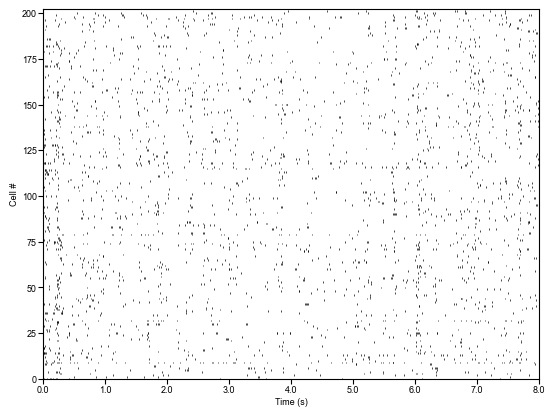

Time since last sync = 37.56 s


In [11]:
# plot trial raster plot

plot_i_trial = 1

plot_font_size = 6.5

plot_spike_events = roi_spike_events[:, plot_i_trial, :]

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

fig = plt.figure()
plt_xs = np.arange(plot_spike_events.shape[1])
event_xs = []
for i_trail in range(plot_spike_events.shape[0]):
    event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])
plt.eventplot(event_xs, color = "black",
              lineoffsets = 1,
              linelengths = 1,
              linewidths = 0.5)

# stim_time_stamp_axvspan(stim_tstamp)

plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_numeric_label_font_size, fontname = "arial", labelpad = 2)
plt.xlim(left = plot_x_ticks[0],
         right = plot_x_ticks[-1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Cell #", 
           fontsize = plot_numeric_label_font_size, fontname = "arial", labelpad = 2)

plot_ax = plt.gca()

plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_numeric_label_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_numeric_label_font_size)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

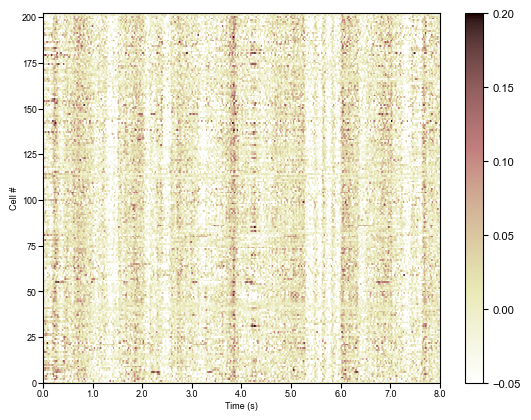

Time since last sync = 37.86 s


In [12]:
# plot subtreshold activities

plot_i_trial = 1

plot_font_size = 6.5

plot_subthd_dFFs = roi_subthd_dFFs[:, plot_i_trial, :]

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

fig = plt.figure()
plt.imshow(plot_subthd_dFFs,
           aspect = "auto",
           interpolation = "none",
           cmap = "pink_r",
           vmin = -0.05,
           vmax = 0.2,
          )
plt.colorbar()

plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_font_size, fontname = "arial", labelpad = 2)
plt.xlim(left = plot_x_ticks[0],
         right = plot_x_ticks[-1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Cell #", 
           fontsize = plot_font_size, fontname = "arial", labelpad = 2)

plot_ax = plt.gca()

plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [13]:
dst_plot_subdir_path = os.path.join(dst_dir_path, dst_plot_subdir_name)

if not os.path.isdir(dst_plot_subdir_path):
    os.makedirs(dst_plot_subdir_path)

print(dst_plot_subdir_path)

preview_subdir_name = "preview"
preview_subdir_path = os.path.join(dst_plot_subdir_path, preview_subdir_name)

if not os.path.isdir(preview_subdir_path):
    os.makedirs(preview_subdir_path)

print(preview_subdir_path)

SAVE_PROGRESS(HISTORY_FILEPATH)

J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures_ver01_supp
J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures_ver01_supp\preview
Time since last sync = 37.90 s


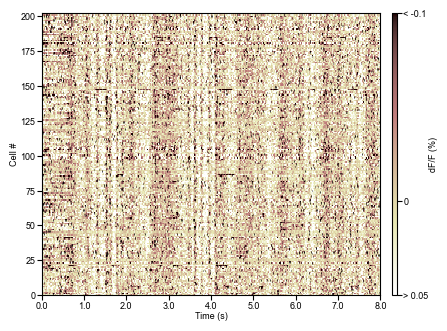

file saved to:J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures_ver01_supp\preview\preview_trial_raster_trial36.png
Time since last sync = 45.54 s


In [35]:
# plot spike events and subthreshold activtiy

plot_i_trial = 36
# plot_i_trial = 7


plot_font_size = 6.5

plot_vmin = -0.05
plot_vmax = 0.1

plot_spike_events = roi_spike_events[:, plot_i_trial, :]
plot_subthd_dFFs = roi_subthd_dFFs[:, plot_i_trial, :]
# plot_subthd_dFFs = raw_dFFs[:, plot_i_trial, :]


plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts


plt_xs = np.arange(plot_spike_events.shape[1])
event_xs = []
for i_trail in range(plot_spike_events.shape[0]):
    event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

preview_figure_name = f"preview_trial_raster_trial{plot_i_trial}"
dst_png_figure_path = os.path.join(preview_subdir_path, preview_figure_name + ".png")

fig_width = letter_paper_size_inch[0] * (5/8)
fig_height = letter_paper_size_inch[1] * (1/3)

fig = plt.figure(figsize = (fig_width, fig_height))

plot_ax = plt.gca()

plt.imshow(plot_subthd_dFFs,
           aspect = "auto",
           interpolation = "none",
           cmap = "pink_r",
           vmin = plot_vmin,
           vmax = plot_vmax,
           alpha = 1,
          )
cbar = plt.colorbar(ax = plot_ax, 
                    location = "right",
                    pad=0.027, 
                    aspect = 50,
                    ticks=[plot_vmin, 0, plot_vmax]
                   )
cbar.ax.set_yticklabels([f"> {-plot_vmin}", "0", f"< {-plot_vmax}"])
cbar.ax.tick_params(labelsize=plot_font_size, 
                    rotation = 0, 
                    pad = 1) 

cbar.set_label(label = "dF/F (%)", 
               # loc = "bottom",
               fontsize = plot_font_size, fontname = "arial", labelpad = 0)

plt.eventplot(event_xs, color = "black",
              lineoffsets = 1,
              linelengths = 1,
              linewidths = 0.5)

plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_font_size, fontname = "arial", labelpad = 1)
plt.xlim(left = plot_x_ticks[0],
         right = plot_x_ticks[-1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Cell #", 
           fontsize = plot_font_size, fontname = "arial", labelpad = 1)


plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size)

fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight')

plt.show()

print("file saved to:" + dst_png_figure_path)

SAVE_PROGRESS(HISTORY_FILEPATH)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


plot saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures_ver01_supp\trial_raster_plot_trial13_ver01.pdf
pickle dump to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures_ver01_supp\trial_raster_plot_trial13_ver01.pickle
data saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures_ver01_supp\trial_raster_plot_trial13_ver01.hdf5


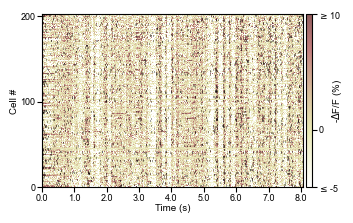

Time since last sync = 89.00 s


In [21]:
# plot spike events and subthreshold activtiy

plot_i_trial = 13
# plot_i_trial = 7

plot_font_size = 6.5

# plot_vmin = -0.1
# plot_vmax = +0.05

plot_vmin = -0.05
plot_vmax = +0.1

# plot_cmap = "pink"
plot_cmap = truncate_pink_r
plot_spike_color = "black"

plot_spike_events = roi_spike_events[:, plot_i_trial, :]
plot_subthd_dFFs = roi_subthd_dFFs[:, plot_i_trial, :]

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

plot_y_ticks = np.arange(0, plot_spike_events.shape[0], 100)
plot_y_labels = plot_y_ticks

dst_figure_name = f"trial_raster_plot_trial{plot_i_trial}_ver01"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

plt_xs = np.arange(plot_spike_events.shape[1])
event_xs = []
for i_trail in range(plot_spike_events.shape[0]):
    event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

fig_width = letter_paper_size_inch[0] * paper_to_illustrator_ratio[0] * (9/16)
# fig_width = letter_paper_size_inch[0] * paper_to_illustrator_ratio[0] * (1/2)
fig_height = letter_paper_size_inch[1] * paper_to_illustrator_ratio[1] * (1/4)

fig = plt.figure(figsize = (fig_width, fig_height))

plot_ax = plt.gca()

plt.imshow(plot_subthd_dFFs,
           aspect = "auto",
           interpolation = "none",
           cmap = plot_cmap,
           vmin = plot_vmin,
           vmax = plot_vmax,
           alpha = 1,
          )
cbar = plt.colorbar(ax = plot_ax, 
                    location = "right",
                    pad=0.01, 
                    aspect = 30,
                    ticks=[plot_vmin, 0, plot_vmax]
                   )
cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
# cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
cbar.ax.tick_params(
        which='both',
        labelsize=plot_numeric_label_font_size, 
        rotation = 0, 
        pad = 1,
) 

cbar.set_label(
    # label = "dF/F (%)", 
    label = "-$\mathrm{\Delta}$F/F (%)",
    # loc = "bottom",
    fontsize = plot_axis_label_font_size, 
    fontname = "Arial", labelpad = -8)

plt.eventplot(event_xs, color = plot_spike_color,
              lineoffsets = 1,
              linelengths = 1,
              linewidths = 0.5)

plt.yticks(ticks = plot_y_ticks, labels = plot_y_labels)
plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_axis_label_font_size, fontname = "Arial", labelpad = 1)
# plt.xlim(left = plot_x_ticks[0],
#          right = plot_x_ticks[-1])
plt.xlim(left = 0,
         right = plot_spike_events.shape[1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Cell #", 
           fontsize = plot_axis_label_font_size, fontname = "Arial", labelpad = 1)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(2,2), useMathText=True,)

plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_numeric_label_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_numeric_label_font_size, pad = 1)


fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight')
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
    hdf5_file.create_dataset("plot_i_trial", data = plot_i_trial)
    hdf5_file.create_dataset("plot_dt_s", data = plot_dt_s)
    hdf5_file.create_dataset("plot_x_ticks", data = plot_x_ticks)
    hdf5_file.create_dataset("plot_x_labels", data = plot_x_labels)
    hdf5_file.create_dataset("plt_xs", data = plt_xs)
    for i_elem in range(len(event_xs)):
        hdf5_file.create_dataset(f"event_xs[{i_elem}]", data = event_xs[i_elem])
    hdf5_file.create_dataset("plot_spike_events", data = plot_spike_events)
    hdf5_file.create_dataset("plot_subthd_dFFs", data = plot_subthd_dFFs)

%notebook $dst_notebook_path
                             
print("plot saved to: " + dst_pdf_figure_path)
print("pickle dump to: " + dst_pkl_figure_path)
print("data saved to: " + dst_hdf5_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


plot saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures_ver01_supp\trial_raster_plot_trial13_split.pdf
pickle dump to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures_ver01_supp\trial_raster_plot_trial13_split.pickle
data saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures_ver01_supp\trial_raster_plot_trial13_split.hdf5


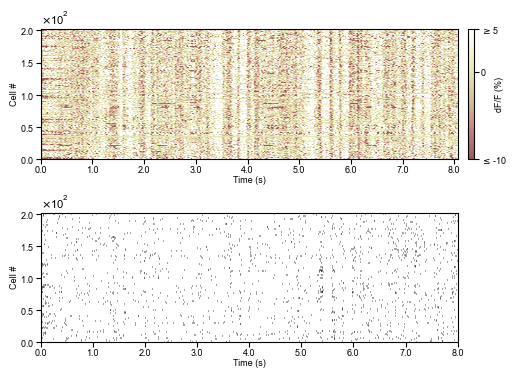

Time since last sync = 27.77 s


In [16]:
# plot spike events and subthreshold activtiy seperately

plot_i_trial = 13
# plot_i_trial = 7

plot_font_size = 6.5

plot_vmin = -0.1
plot_vmax = +0.05

# plot_cmap = "pink"
plot_cmap = truncate_pink
plot_spike_color = "black"

plot_spike_events = roi_spike_events[:, plot_i_trial, :]
plot_subthd_dFFs = -roi_subthd_dFFs[:, plot_i_trial, :]
# plot_subthd_dFFs = -raw_dFFs[:, plot_i_trial, :]

plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

dst_figure_name = f"trial_raster_plot_trial{plot_i_trial}_split"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

plt_xs = np.arange(plot_spike_events.shape[1])
event_xs = []
for i_trail in range(plot_spike_events.shape[0]):
    event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

# fig_width = letter_paper_size_inch[0] * (19/32)
# fig_height = letter_paper_size_inch[1] * (1/6)


fig_width = letter_paper_size_inch[0] * (19/32)
fig_height = letter_paper_size_inch[1] * (1/3)


fig = plt.figure(
                figsize = (fig_width, fig_height),
                layout="constrained",
)

gs = mpl_gridspec.GridSpec(2,1, figure = fig)

# plot_ax = plt.gca()
plot_ax = plt.subplot(gs[0,0])

plt.imshow(plot_subthd_dFFs,
           aspect = "auto",
           interpolation = "none",
           cmap = plot_cmap,
           vmin = plot_vmin,
           vmax = plot_vmax,
           alpha = 1,
          )
cbar = plt.colorbar(ax = plot_ax, 
                    location = "right",
                    pad=0.01, 
                    aspect = 20,
                    ticks=[plot_vmin, 0, plot_vmax]
                   )
cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
cbar.ax.tick_params(labelsize=plot_font_size, 
                    rotation = 0, 
                    pad = 1) 

cbar.set_label(label = "dF/F (%)", 
               # loc = "bottom",
               fontsize = plot_font_size, fontname = "Arial", labelpad = -8)

plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
# plt.xlim(left = plot_x_ticks[0],
#          right = plot_x_ticks[-1])
plt.xlim(left = 0,
         right = plot_spike_events.shape[-1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Cell #", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(2,2), useMathText=True,)

plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size)


plot_ax = plt.subplot(gs[1,0])
plt.eventplot(event_xs, color = plot_spike_color,
              lineoffsets = 1,
              linelengths = 1,
              linewidths = 0.5)

plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
plt.xlim(left = plot_x_ticks[0],
         right = plot_x_ticks[-1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Cell #", 
           fontsize = plot_font_size, fontname = "Arial", labelpad = 1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(2,2), useMathText=True,)

plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_font_size)


fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight')
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
    hdf5_file.create_dataset("plot_i_trial", data = plot_i_trial)
    hdf5_file.create_dataset("plot_dt_s", data = plot_dt_s)
    hdf5_file.create_dataset("plot_x_ticks", data = plot_x_ticks)
    hdf5_file.create_dataset("plot_x_labels", data = plot_x_labels)
    hdf5_file.create_dataset("plt_xs", data = plt_xs)
    for i_elem in range(len(event_xs)):
        hdf5_file.create_dataset(f"event_xs[{i_elem}]", data = event_xs[i_elem])
    hdf5_file.create_dataset("plot_spike_events", data = plot_spike_events)
    hdf5_file.create_dataset("plot_subthd_dFFs", data = plot_subthd_dFFs)

%notebook $dst_notebook_path
                             
print("plot saved to: " + dst_pdf_figure_path)
print("pickle dump to: " + dst_pkl_figure_path)
print("data saved to: " + dst_hdf5_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


plot saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures_ver01_supp\trial_dff_raster_plot_trial13_ver0p1.pdf
pickle dump to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures_ver01_supp\trial_dff_raster_plot_trial13_ver0p1.pickle
data saved to: J:\2023-10-10\M377_JEDI2P\FOV03\Group01\StatsAnalysisSubtresholds_Ver05_FromVer01_20Hz5OrderBW_CorrectMeanTiming_New\figures_ver01_supp\trial_dff_raster_plot_trial13_ver0p1.hdf5


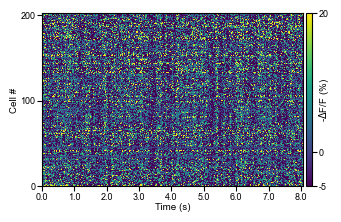

Time since last sync = 88.59 s


In [14]:
# plot spike events and subthreshold activtiy

plot_i_trial = 13
# plot_i_trial = 7

plot_font_size = 6.5

# plot_vmin = -0.1
# plot_vmax = +0.05

plot_vmin = -0.05
plot_vmax = +0.20

# plot_cmap = "pink"
# plot_cmap = truncate_pink_r
plot_cmap = "viridis"
# plot_spike_color = "black"

# plot_spike_events = roi_spike_events[:, plot_i_trial, :]
# plot_subthd_dFFs = roi_subthd_dFFs[:, plot_i_trial, :]
plot_dFFs = dFF_s[:, plot_i_trial, :]


plot_dt_s = time_per_frame_ms * ms_to_s
plot_ts = np.linspace(0,8,9)
plot_x_ticks = (plot_ts/plot_dt_s).astype(int)
plot_x_labels = plot_ts

plot_y_ticks = np.arange(0, plot_spike_events.shape[0], 100)
plot_y_labels = plot_y_ticks

dst_figure_name = f"trial_dff_raster_plot_trial{plot_i_trial}_ver0p1"

dst_png_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".png")
dst_eps_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".eps")
dst_pdf_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pdf")
dst_pkl_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".pickle")
dst_hdf5_figure_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".hdf5")
dst_notebook_path = os.path.join(dst_plot_subdir_path, dst_figure_name + ".ipynb")

plt_xs = np.arange(plot_spike_events.shape[1])
event_xs = []
for i_trail in range(plot_spike_events.shape[0]):
    event_xs.append(plt_xs[plot_spike_events[i_trail,:] > 0])

fig_width = letter_paper_size_inch[0] * paper_to_illustrator_ratio[0] * (9/16)
# fig_width = letter_paper_size_inch[0] * paper_to_illustrator_ratio[0] * (1/2)
fig_height = letter_paper_size_inch[1] * paper_to_illustrator_ratio[1] * (1/4)

fig = plt.figure(figsize = (fig_width, fig_height))

plot_ax = plt.gca()

plt.imshow(plot_dFFs,
           aspect = "auto",
           interpolation = "none",
           cmap = plot_cmap,
           vmin = plot_vmin,
           vmax = plot_vmax,
           alpha = 1,
          )
cbar = plt.colorbar(ax = plot_ax, 
                    location = "right",
                    pad=0.01, 
                    aspect = 30,
                    ticks=[plot_vmin, 0, plot_vmax]
                   )
# cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
# cbar.ax.set_yticklabels([f"$\leq${plot_vmin*1E2:.0f}", "0", f"$\geq${plot_vmax*1E2:.0f}"])
cbar.ax.set_yticklabels([f"{plot_vmin*1E2:.0f}", "0", f"{plot_vmax*1E2:.0f}"])
cbar.ax.tick_params(
        which='both',
        labelsize=plot_numeric_label_font_size, 
        rotation = 0, 
        pad = 1,
) 

cbar.set_label(
    # label = "dF/F (%)", 
    label = "-$\mathrm{\Delta}$F/F (%)",
    # loc = "bottom",
    fontsize = plot_axis_label_font_size, 
    fontname = "Arial", labelpad = -8)

# plt.eventplot(event_xs, color = plot_spike_color,
#               lineoffsets = 1,
#               linelengths = 1,
#               linewidths = 0.5)

plt.yticks(ticks = plot_y_ticks, labels = plot_y_labels)
plt.xticks(ticks = plot_x_ticks, labels = plot_x_labels)
plt.xlabel("Time (s)", 
           fontsize = plot_axis_label_font_size, fontname = "Arial", labelpad = 1)
# plt.xlim(left = plot_x_ticks[0],
#          right = plot_x_ticks[-1])
plt.xlim(left = 0,
         right = plot_spike_events.shape[1])
plt.ylim(bottom = 0,
         top = plot_spike_events.shape[0])
plt.ylabel("Cell #", 
           fontsize = plot_axis_label_font_size, fontname = "Arial", labelpad = 1)
# plt.ticklabel_format(style='sci', axis='y', scilimits=(2,2), useMathText=True,)

plot_ax.tick_params(axis='both', which='major', 
                        labelsize=plot_numeric_label_font_size, pad = 1)
plot_ax.tick_params(axis='both', which='minor', 
                        labelsize=plot_numeric_label_font_size, pad = 1)


fig.savefig(dst_png_figure_path, format = "png", bbox_inches = 'tight')
fig.savefig(dst_eps_figure_path, format = "eps", bbox_inches = 'tight')
fig.savefig(dst_pdf_figure_path, format = "pdf", bbox_inches = 'tight')

with open(dst_pkl_figure_path, "wb") as dst_pkl_file:
    pickle.dump(fig, dst_pkl_file)

with h5py.File(dst_hdf5_figure_path, "w") as hdf5_file:
    hdf5_file.create_dataset("plot_i_trial", data = plot_i_trial)
    hdf5_file.create_dataset("plot_dt_s", data = plot_dt_s)
    hdf5_file.create_dataset("plot_x_ticks", data = plot_x_ticks)
    hdf5_file.create_dataset("plot_x_labels", data = plot_x_labels)
    hdf5_file.create_dataset("plt_xs", data = plt_xs)
    for i_elem in range(len(event_xs)):
        hdf5_file.create_dataset(f"event_xs[{i_elem}]", data = event_xs[i_elem])
    hdf5_file.create_dataset("plot_spike_events", data = plot_spike_events)
    hdf5_file.create_dataset("plot_subthd_dFFs", data = plot_subthd_dFFs)

%notebook $dst_notebook_path
                             
print("plot saved to: " + dst_pdf_figure_path)
print("pickle dump to: " + dst_pkl_figure_path)
print("data saved to: " + dst_hdf5_figure_path)

plt.show()

SAVE_PROGRESS(HISTORY_FILEPATH)

In [38]:
print(dFF_s.shape)

(202, 37, 3100)
